In [1]:
import sklearn
sklearn.__version__

'1.3.1'

In [2]:
import pandas as pd   
from matplotlib import pyplot
from numpy import mean
import time


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler


def missing_value_counts(dataframe):
    # Calculate the count of missing values in each column
    missing_counts = dataframe.isnull().sum()

    # Create a DataFrame to display the results
    missing_counts_df = pd.DataFrame({'Column': missing_counts.index, 'Missing_Values_Count': missing_counts.values})

    return missing_counts_df

# missing_value_counts(imputed_df)

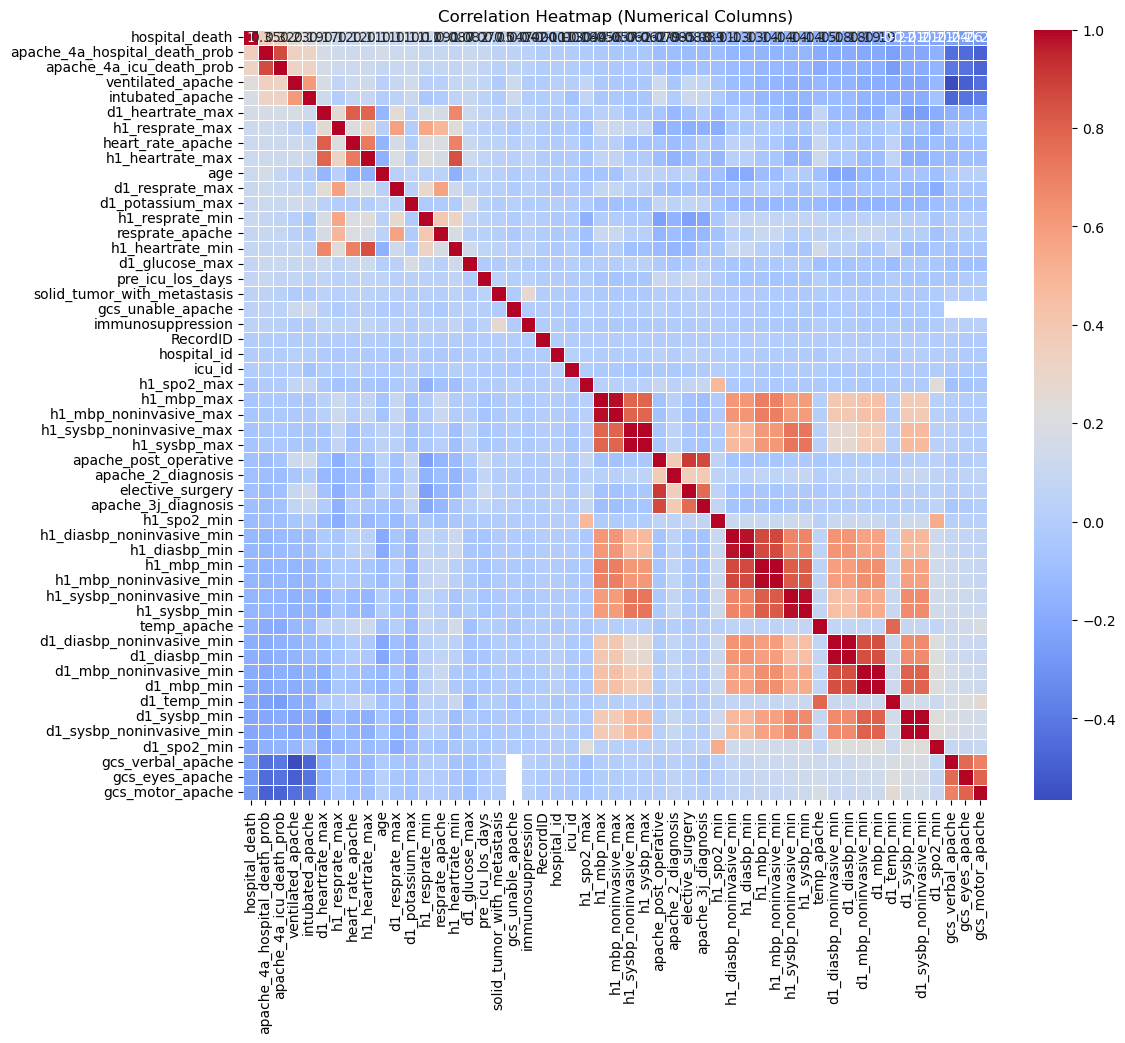

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your DataFrame (replace 'your_data.csv' with your actual data file)
df = pd.read_csv('train.csv')

# Select only the numerical columns
numerical_df = df.select_dtypes(include=[np.number])


# Min-max scale the numerical columns
scaler = MinMaxScaler()
scaled_numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns=numerical_df.columns)


# Create a correlation matrix from the numerical DataFrame
correlation_matrix = numerical_df.corr()

# Get the column names in order of highest correlation
sorted_columns = correlation_matrix['hospital_death'].sort_values(ascending=False).index

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.loc[sorted_columns, sorted_columns], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Columns)')
plt.show()


In [4]:
df1 = pd.read_csv("train.csv")
df1.head()
df1.drop(['RecordID', 'hospital_id'], axis=1, inplace=True)


In [5]:
print(df1.shape)
# print(df1.dtypes) 

(50000, 56)


In [6]:
df_onehot = pd.get_dummies(df1)
print(df_onehot.dtypes)
print(df_onehot.shape)

icu_id                                       int64
age                                        float64
elective_surgery                             int64
pre_icu_los_days                           float64
apache_2_diagnosis                         float64
                                            ...   
apache_2_bodysystem_Renal/Genitourinary       bool
apache_2_bodysystem_Respiratory               bool
apache_2_bodysystem_Trauma                    bool
apache_2_bodysystem_Undefined Diagnoses       bool
apache_2_bodysystem_Undefined diagnoses       bool
Length: 94, dtype: object
(50000, 94)


In [7]:
X = df_onehot.loc[:, df_onehot.columns != "hospital_death"]
y = df_onehot[["hospital_death"]]

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np

def impute_numerical_columns(df):
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns

    # Create a SimpleImputer instance
    imputer = SimpleImputer(strategy="mean")

    # Fit and transform the imputer on the numerical columns
    df.loc[:, numerical_columns] = imputer.fit_transform(df.loc[:, numerical_columns])

    scaler = MinMaxScaler()

    # Fit and transform the scaler on the numerical columns
    df.loc[:, numerical_columns] = scaler.fit_transform(df.loc[:, numerical_columns])

    return df

# Usage example:
df1 = impute_numerical_columns(df1)


In [9]:
# print(missing_value_counts(X))
impute_numerical_columns(X)
missing_value_counts(X)
cols_with_missing_values = X.columns[X.isnull().any()]
print(cols_with_missing_values)
# X.head()



Index([], dtype='object')


In [10]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.1, random_state=5)

In [11]:
dt_7_3 = DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=5, min_samples_leaf=10)  
dt_7_3.fit(trainX,trainy)
# dt_7_3.fit(X,y)
#fit_model(dt_5_2, "Depth 5 Split 2") 
md_probs = dt_7_3.predict_proba(testX)

# print(md_probs)

md_probs = md_probs[:,1]
# print(md_probs)

md_auc = roc_auc_score(testy, md_probs)
md_auc


0.8474553457839296

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def find_best_decision_tree_params(trainX, trainy, testX, testy):
    # Define the parameter grid to search
    param_grid = {
        'max_depth': [5, 6, 7, 8],               # Vary the maximum depth
        'min_samples_split': [2,3, 4,5, 6,7, 8,9,10],      # Vary the minimum samples for split
        'min_samples_leaf': [2,3 ,4,5, 6,7, 8,9, 10]        # Vary the minimum samples per leaf
    }

    # Create a DecisionTreeClassifier
    dt_classifier = DecisionTreeClassifier(random_state=5)

    # Initialize GridSearchCV with ROC AUC scoring
    grid_search = GridSearchCV(dt_classifier, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(trainX, trainy)

    # Get the best parameters and estimator from the grid search
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Predict probabilities on the test set using the best estimator
    md_probs = best_estimator.predict_proba(testX)[:, 1]

    # Calculate ROC AUC score on the test set
    md_auc = roc_auc_score(testy, md_probs)

    return best_params, best_estimator, md_auc

# Usage example:
best_params, best_estimator, best_auc = find_best_decision_tree_params(trainX, trainy, testX, testy)
print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_auc)


Best Parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best ROC AUC Score: 0.8474553457839296


In [14]:
dt_7_3.fit(X,y)


DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=3,
                       random_state=5)

In [15]:
clf = dt_7_3
cv = RepeatedKFold(n_splits=10, n_repeats=2)


start = time.perf_counter()
accuracy = cross_val_score(clf, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
scores = cross_val_score(clf, X, y, scoring="roc_auc", cv=cv, n_jobs=-1) 
end = time.perf_counter()        
score = format(mean(scores), '.4f')
duration = format((end-start), '.4f')
accuracy = format(mean(accuracy), '.4f')

print(": score:{} - time taken:{} - accuracy:{}".format(score, duration, accuracy))


: score:0.8489 - time taken:3.9635 - accuracy:0.9221


In [16]:
# def fit_model(model, model_name):
#     model.fit(trainX,trainy)
#     md_probs = model.predict_proba(testX)
#     md_probs = md_probs[:,1]
#     md_auc = roc_auc_score(testy, md_probs)
#     print(model_name, " : ", md_auc)
#     md_fpr, md_tpr, _ = roc_curve(testy, md_probs)
#     pyplot.plot(md_fpr, md_tpr, marker='.', label=model_name)
#     #return (md_fpr, md_tpr)
    

In [17]:
# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.1)#, random_state=2)
# dt_5_2 = DecisionTreeClassifier(max_depth=5)  
# fit_model(dt_5_2, "Depth 5 Split 2") 

# dt_7_2 = DecisionTreeClassifier(max_depth=7)  
# fit_model(dt_7_2, "Depth 7 Split 2") 

# dt_5_5 = DecisionTreeClassifier(max_depth=5, min_samples_split=5)  
# fit_model(dt_5_5, "Depth 5 Split 5") 

# dt_7_5 = DecisionTreeClassifier(max_depth=7, min_samples_split=5)  
# fit_model(dt_7_5, "Depth 7 Split 5") 

# dt_3_2 = DecisionTreeClassifier(max_depth=3, min_samples_split=2)  
# fit_model(dt_3_2, "Depth 3 Split 2") 

# dt_3_5 = DecisionTreeClassifier(max_depth=3, min_samples_split=5)  
# fit_model(dt_3_5, "Depth 3 Split 5") 

# #kn = KNeighborsClassifier(n_neighbors=5)
# #fit_model(kn, "k-NN")

# #pipe_kn = Pipeline([("scaler", MinMaxScaler()), ("knr", KNeighborsClassifier(n_neighbors=5))])
# #fit_model(pipe_kn, "Scaled k-NN")

# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

In [18]:
def fitting_models_CV2(X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=2)
    
    # dt_5_2 = DecisionTreeClassifier(max_depth=5, )  
    # dt_7_2 = DecisionTreeClassifier(max_depth=7)  
    # dt_5_5 = DecisionTreeClassifier(max_depth=5, min_samples_split=5)  
    # dt_7_5 = DecisionTreeClassifier(max_depth=7, min_samples_split=5)  
    dt_7_3 = DecisionTreeClassifier(max_depth=7, min_samples_split=3, min_samples_leaf=3)  
    clfs = [
            # ('Depth 5 Split 2', dt_5_2),        
            # ('Depth 7 Split 2', dt_7_2),        
            # ('Depth 5 Split 5', dt_5_5),
            # ('Depth 7 Split 5', dt_7_5),
            ('Depth 10 Split 2', dt_7_3)
            
           ]

    models = []
    for name, clf in clfs:
        clf.fit(X, y)  # Fit the model to your data
        models.append((name, clf))  # Store the trained model
        
        start = time.perf_counter()
        accuracy = cross_val_score(clf, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
        scores = cross_val_score(clf, X, y, scoring="roc_auc", cv=cv, n_jobs=-1) 
        end = time.perf_counter()        
        score = format(mean(scores), '.4f')
        duration = format((end-start), '.4f')
        accuracy = format(mean(accuracy), '.4f')
        
        print("{} : score:{} - time taken:{} - accuracy:{}".format(name, score, duration, accuracy))
    
    return models


In [19]:
# models = fitting_models_CV2(X,y)


In [20]:
# import numpy as np

# def generate_predictions(models, test_file):
#     df_test = pd.read_csv(test_file)
#     df_test_onehot = pd.get_dummies(df_test)
#     X_test = df_test_onehot.loc[:, df_test_onehot.columns != "hospital_death"]
#     record_ids = df_test["RecordID"]
#     predictions = []
#     for name, model in models:
        
#         probs = model.predict_proba(X_test)
#         probs = probs[:,1]
#         predictions.append(probs)
#     predictions = np.array(predictions)
#     predictions = np.mean(predictions, axis=0)
#     result = pd.DataFrame({'RecordID': record_ids, 'hospital_death': predictions})
#     return result


# results = generate_predictions(models, "test.csv")
# results.to_csv("results4.csv", index=False, header=["RecordID", "hospital_death"])


In [21]:
def generate_predictions_for_model(model, test_file, output_file):
    # Load the test data
    df_test = pd.read_csv(test_file)
    record_ids = df_test["RecordID"]
    df_test.drop(['RecordID', 'hospital_id'], axis=1, inplace=True)
    
    impute_numerical_columns(df_test)
    
    df_test_onehot = pd.get_dummies(df_test)
    X_test = df_test_onehot.loc[:, df_test_onehot.columns != "hospital_death"]
    
    
    # Generate predictions using the model
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    
    # Create a DataFrame for the results
    result = pd.DataFrame({'RecordID': record_ids, 'hospital_death': probs})
    
    # Save the results to a CSV file
    result.to_csv(output_file, index=False, header=["RecordID", "hospital_death"])
    
generate_predictions_for_model(dt_7_3, "test.csv", "results7.csv")
